In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as scp
import sklearn as sk
import seaborn as sns
from stable_baselines3.common.results_plotter import rolling_window

KeyboardInterrupt: 

## preprocessing

In [2]:
raw_data = scp.io.arff.loadarff('data/EEG Eye State.arff')
df = pd.DataFrame(raw_data[0])

df['eyeDetection'] = df['eyeDetection'].apply(lambda x: int(x.decode()))
feature_cols = df.columns[:-1]
X = df[feature_cols]
y = df[df.columns[-1]]

## initial visualisation

In [3]:
# standardise the data
scaler = sk.preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)

## PCA

In [4]:
init_pca = sk.decomposition.PCA(n_components=14)
init_pca_fit = init_pca.fit(X_scaled)

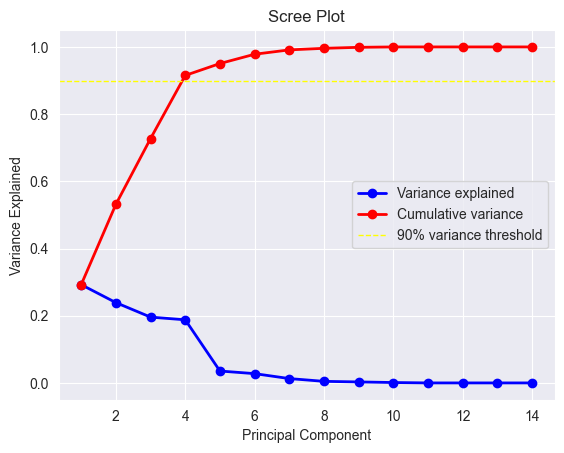

In [5]:
init_PC_values = np.arange(init_pca.n_components_) + 1
init_variance = np.cumsum(init_pca.explained_variance_ratio_)

plt.plot(init_PC_values, init_pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue', label='Variance explained')
plt.plot(init_PC_values, init_variance, 'o-', linewidth=2, color='red', label='Cumulative variance')
plt.axhline(y=0.9, color='yellow', linestyle='--', linewidth=1, label='90% variance threshold')

plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')

plt.legend()
plt.show()

The drop in the scree plot is at PC4. the first 4 components account for 91.5% of the total variance. Therefore, I will only use the first four to look for clusters/patterns.

In [6]:
pca = sk.decomposition.PCA(n_components=4)
X_pca = pca.fit_transform(X_scaled)

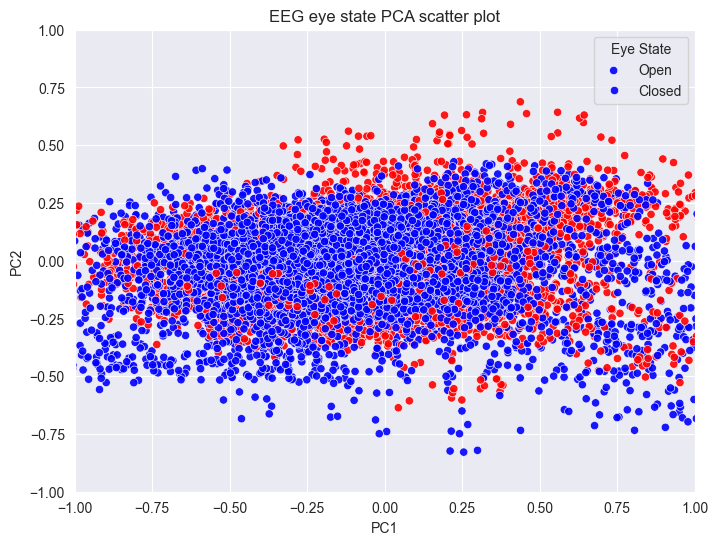

In [7]:
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3', 'PC4'])
pca_df['eyeDetection'] = y.values

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=pca_df,
    x='PC1',
    y='PC2',
    hue='eyeDetection',
    palette={0:'blue', 1:'red'},
    alpha=0.9
)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('EEG eye state PCA scatter plot')
plt.legend(title='Eye State', labels=['Open', 'Closed'])
plt.show()

In [8]:
# g = sns.pairplot(data=pca_df, hue='eyeDetection', palette={0: 'blue', 1: 'red'})
#
#
# for ax in g.axes.flatten():
#     xlab = ax.get_xlabel()
#     ylab = ax.get_ylabel()
#
#     if xlab: # Check if x-axis label exists
#         ax.set_xlim(-1.5, 1.5)
#     if ylab: # Check if y-axis label exists
#         ax.set_ylim(-1.5, 1.5)
#
# plt.show()


In [9]:
# def knn_k_fold():
#     return

In [10]:
# k_vals = [i for i in range(2, 6)]
# scores = []
#
# # X_scaled
# for k in k_vals:
#     knn = sk.neighbors.KNeighborsClassifier(n_neighbors=k)
#     score = sk.model_selection.cross_val_score(knn, X_pca, y, cv=10)
#     scores.append(np.mean(score))
#
# print(scores)

In [11]:
# svm = sk.svm.SVC(kernel='rbf')
# score = sk.model_selection.cross_val_score(svm, X_pca, y, cv=3)
# print(score.mean())

In [12]:
# clf = sk.ensemble.RandomForestClassifier(n_estimators=300)
# scores = sk.model_selection.cross_val_score(clf, X_scaled, y, cv=3)
# print(scores.mean())

Low accuracies - decided to research smoothing techniques. Found moving average: choose a fixed window (increment by some step) and calculate the average over it, then train on that.

In [38]:
smooth_scaler = sk.preprocessing.StandardScaler()

X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.2, shuffle=False)
X_train_scaled, X_test_scaled = smooth_scaler.fit_transform(X_train), smooth_scaler.transform(X_test)

# 80/65 - 67%

window_size = 80
step = 65

def moving_average(X, y):
    i = 0
    X_w, y_w = [], []
    while (i+window_size) <= X.shape[0]:
        w = X[i:i+window_size, :]
        means = w.mean(axis=0)
        label = int(y.iloc[i])
        X_w.append(means)
        y_w.append(label)
        i += step
    return np.vstack(X_w), np.vstack(y_w).ravel()

X_train_smoothed, y_train_smoothed = moving_average(X_train_scaled, y_train)
X_test_smoothed, y_test_smoothed = moving_average(X_test_scaled, y_test)

model = sk.neighbors.KNeighborsClassifier(n_neighbors = 2)
model.fit(X_train_smoothed, y_train_smoothed)
accuracy = model.score(X_test_smoothed, y_test_smoothed)
print(f'final test acc: {accuracy:.4f}')

final test acc: 0.6667
